dataset:

---

https://github.com/liaopeiyuan/artbench

experiments to try:

1. fine tune basic just learning rate (DONE)
2. train only froozen layeres for very long time
 (DONE for 15 epochs )
3. like fine tune but manual, check for learning rate in between does result improve
4. augmentations default, train same way does result improve

ideas after: weight decay after cetrain time, change how augmentations are done, larger models, dataset reduced artists, random erasing, mixup, label smoothing, tta, traing from scratch,  etc....

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns ./mlruns
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db ./mlruns.db

In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
!ls mlruns/1

b8d17b3a62ba4f969dae8594895019f8  da50e6ef4b164b57883889fa26942ecb


In [ ]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/

before___should_delete	mlruns	mlruns.db


In [ ]:
# copy mlflow back to server
!cp -r ./mlruns /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data
!cp mlruns.db /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

In [ ]:
!ls  ./mlruns

1


change imports

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

list of all augmentations:

https://github.com/fastai/fastai2/blob/master/nbs/09_vision.augment.ipynb

In [ ]:
from artworks_helpers import genres_sorted_era
from fastai_utils import format_lrs, plot_confusion_matrix_vocab
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/07/08 08:07:29 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/08 08:07:29 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
    'model_name': 'resnet18_pretrained',
}

In [ ]:
paintings_no_transform = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)
dls = paintings_no_transform.dataloaders(path/"train", bs=BATCH_SIZE)

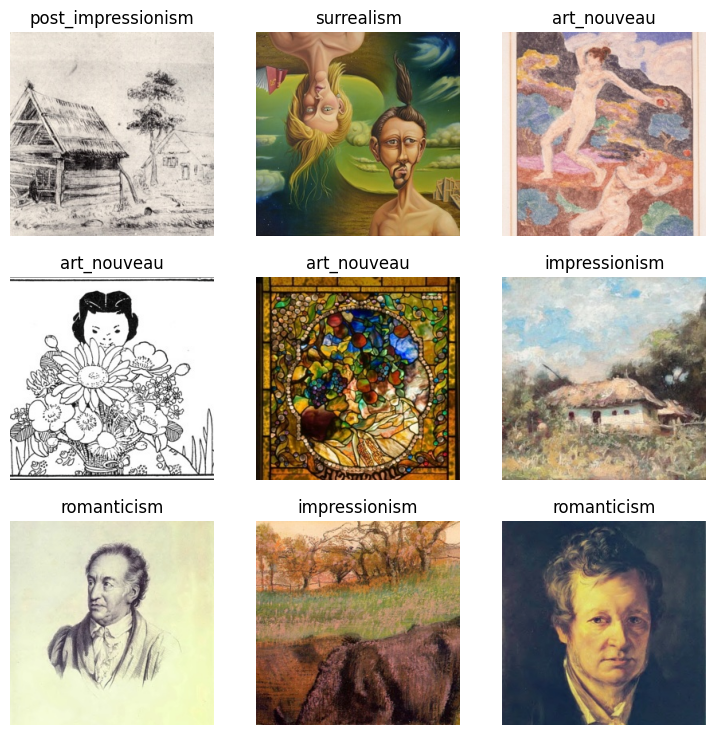

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


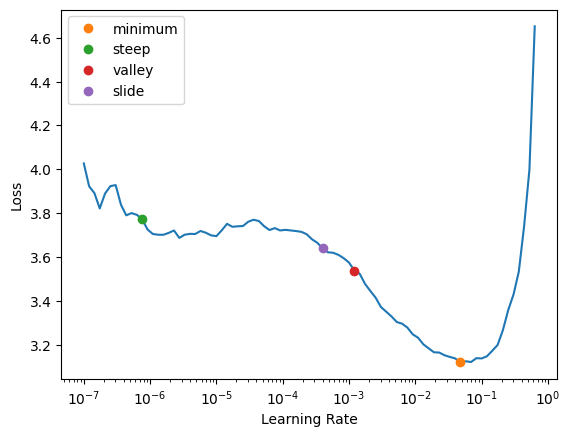

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
format_lrs(learn_rate)

metric: steep,  learning_rate:  0.000001
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: slide,  learning_rate:  0.000398
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: valley,  learning_rate:  0.001202
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: minimum,  learning_rate:  0.004786
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



"training procedure"

**1.)  Procedure only with fine tune out of the box, simnplest baseline.
Model starts to overfit after epoch 4**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_fine_tune') as run:


    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 8}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.fine_tune(run_params['num_epochs'], base_lr=run_params['learning_rate'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.633922,1.319624,0.480800,02:09


epoch,train_loss,valid_loss,error_rate,time
0,1.280421,1.138693,0.420000,02:42
1,1.106072,1.065971,0.393000,02:41
2,0.923794,1.026161,0.380000,02:42
3,0.644394,1.105928,0.384000,02:41
4,0.370620,1.290223,0.381900,02:43
5,0.174166,1.461856,0.382600,02:42
6,0.094016,1.539362,0.379800,02:41
7,0.061379,1.559847,0.381400,02:41


artifact_uri saved as model
runs:/da50e6ef4b164b57883889fa26942ecb/fastai_model/fastai_resnet18_finetune.pkl


**2.) Training of the frozen layers, there is no overfitting even when training for multiple epochs, 15 in this case**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='artworks_classification_resnet18_train_only_frozen') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.0015, 'num_epochs': 15}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=0.99, cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.161475,1.554093,0.543700,02:05
1,1.844958,1.398054,0.495900,02:06
2,1.643578,1.306133,0.470000,02:05
3,1.489819,1.252608,0.455600,02:07
4,1.335841,1.214101,0.442400,02:06
5,1.264485,1.184055,0.434500,02:07
6,1.253578,1.167196,0.428100,02:05
7,1.221916,1.148869,0.430700,02:06
8,1.173563,1.138947,0.424700,02:05
9,1.156616,1.118736,0.415800,02:05


artifact_uri saved as model
runs:/b8d17b3a62ba4f969dae8594895019f8/fastai_model/fastai_resnet18_only_frozen.pkl


Save the plot figure for the loss

In [ ]:
run = get_last_run_id(mlfclient, '1')

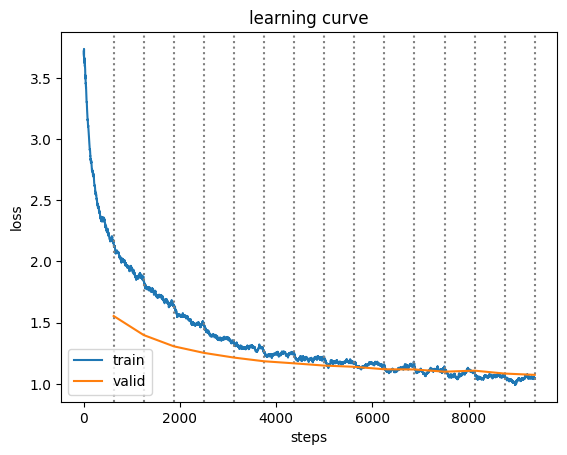

In [ ]:
loss_plot_path = "loss_plot.png"
learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)

In [ ]:
# Log the plot as an artifact to the  MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
        artifact_path='figures')

Save the classification interpetation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
add_methods_to_interpetation(interp)

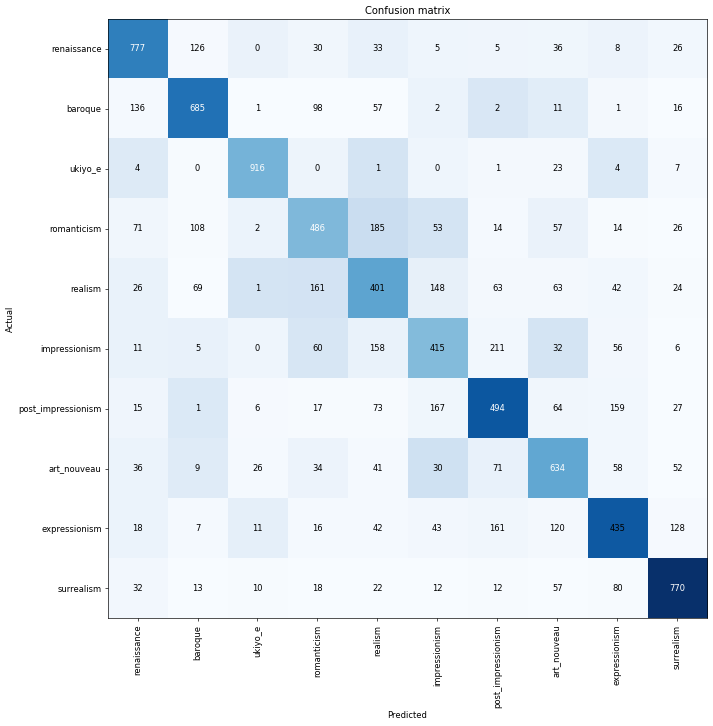

In [ ]:
interp.plot_confusion_matrix_vocab(genres_sorted_era, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')

In [ ]:
mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
        artifact_path='figures' )

With MLflow, you can resume a run that has ended. This is a useful feature for continuing training from a checkpoint or adding more information to an existing run.

> Add blockquote



You can resume a run by using the mlflow.start_run() function with the run_id of the ended run. For example:



In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

  13506 ?        Rl     0:01 /usr/bin/python3 /usr/local/bin/mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000


In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

MLflow Tracking UI: https://d9262d92951b.ngrok-free.app


'https://d9262d92951b.ngrok-free.app'

How to check that most confused counts follow the genres_era_sorted ordering

In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted)
confused_counts = interp.most_confused()

In [ ]:
interp.print_classification_report()

TODO, use vision transforms going forward, do they improve the results

"Does using vision transform make sense, because this are not natural scenes objects"

In [ ]:
paintings_augmented = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SEED_USED, valid_pct=VALID_PERCENTAGE),
                get_y=parent_label,
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = paintings_augmented.dataloaders(path/"train")

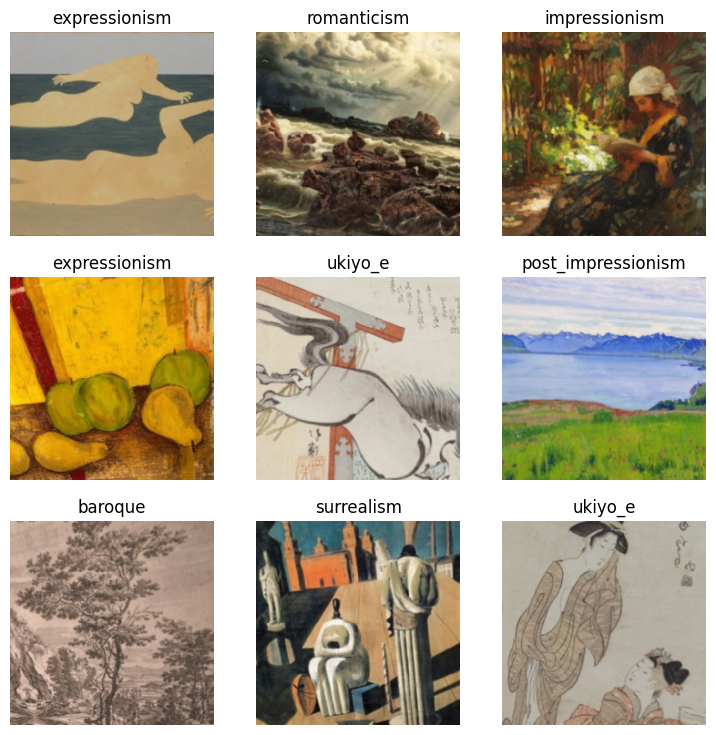

In [ ]:
dls.show_batch()

How to save and load the interpretation object

In [ ]:
import pickle

# Assuming 'interp' is your fastai Interpretation object
interp_path = "interpretation.pkl"
with open(interp_path, "wb") as f:
    pickle.dump(interp, f)

# Log the interpretation object as an artifact to the current MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
        artifact_path='interpetation' )

If you are using cpu, save back to cpu, to avoid the torch error

In [ ]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)



In [ ]:
artifact_path = "interpetation/interpretation.pkl"

# Download the artifact to a local path
local_path = mlfclient.download_artifacts('da50e6ef4b164b57883889fa26942ecb', artifact_path)

# Load the interpretation object from the local path, mapping to CPU
with open(local_path, "rb") as f:

  contents = CPU_Unpickler(f).load()
